## Patient-level data split for all cohorts

In [1]:
# Package(s) need to be installed/updated
#!conda install pandas-gbq --channel conda-forge -y
#!conda install seaborn
#!conda install altair -y

In [2]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from google.cloud import bigquery
from IPython.display import Image
from deep_nexus.preprocess_images import random_split

### Check purity distribution

In [3]:
%%bigquery df_full
SELECT case_barcode, sample_barcode, disease_code, sample_type_name, avg_percent_tumor_cells, file_gcs_url
FROM `deep-nexus.tcga.TCGA_slides_metadata`

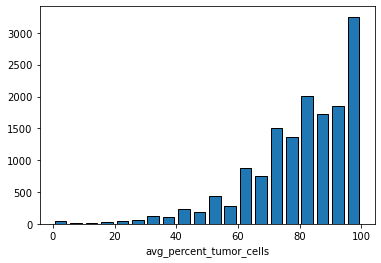

In [4]:
sns.distplot(df_full[df_full.sample_type_name=='Primary solid Tumor'].avg_percent_tumor_cells, bins=20, kde=False,
            hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':1.0});

### Set purity threshold and get data

In [5]:
params = {'avg_percent_tumor_cells': 70}
seed = 123  # for train/test/valid randomization

In [6]:
%%bigquery df_pure --params $params
SELECT case_barcode, sample_barcode, disease_code, sample_type_name, avg_percent_tumor_cells, file_gcs_url
FROM `deep-nexus.tcga.TCGA_slides_metadata`
WHERE is_ffpe ='NO' AND (sample_type_name='Solid Tissue Normal' OR 
                        (sample_type_name='Primary solid Tumor' AND avg_percent_tumor_cells>@avg_percent_tumor_cells))

In [7]:
%%bigquery df_rest --params $params
SELECT case_barcode, sample_barcode, disease_code, sample_type_name, avg_percent_tumor_cells, file_gcs_url
FROM `deep-nexus.tcga.TCGA_slides_metadata`
WHERE is_ffpe ='NO' AND sample_type_name='Primary solid Tumor' AND avg_percent_tumor_cells<=@avg_percent_tumor_cells

### Remove cohorts with <20 slides for tumor or normal

In [8]:
df = pd.concat([df_pure, df_rest], ignore_index=True)

temp = df.groupby(['disease_code', 'sample_type_name']).size().unstack(fill_value=0).stack().reset_index(name='values')
type_count_to_move = temp[temp['values']<20]

disease_code_move_list = list(type_count_to_move['disease_code'].unique())
disease_code_all = df['disease_code'].unique()
disease_code_left = [code for code in disease_code_all if code not in disease_code_move_list]

print("** Move the following {} cohorts **\n".format(len(disease_code_move_list)))
print(disease_code_move_list)

print("\n** The following {} cohorts are left after the filter **\n".format(len(disease_code_left)))
print(disease_code_left)

** Move the following 12 cohorts **

['ACC', 'CESC', 'DLBC', 'GBM', 'LGG', 'MESO', 'PCPG', 'SKCM', 'TGCT', 'THYM', 'UCS', 'UVM']

** The following 20 cohorts are left after the filter **

['HNSC', 'BRCA', 'UCEC', 'COAD', 'LIHC', 'THCA', 'READ', 'BLCA', 'LUAD', 'ESCA', 'STAD', 'LUSC', 'OV', 'KICH', 'PAAD', 'KIRP', 'KIRC', 'PRAD', 'SARC', 'CHOL']


### Two-stage split

In [9]:
df_pure_sub = df_pure[-df_pure['disease_code'].isin(disease_code_move_list)]
df_rest_sub = df_rest[-df_rest['disease_code'].isin(disease_code_move_list)]

print("\n** The total number of slides left after applying the filter **\n")
print(df_pure_sub.shape[0] + df_rest_sub.shape[0])

print("\n** Starting splits... ")

print("\n** The split for the pure slides **\n")

train_df, test_df_pure, valid_df_pure = random_split(df_pure_sub, 
                                                          train_prop = 0.70, 
                                                          test_prop = 0.15, 
                                                          valid_prop = 0.15, seed = seed)
print("\n** The split for the remaining slides **\n")

_, test_df_rest, valid_df_rest = random_split(df_rest_sub, 
                                                train_prop = 0, 
                                                test_prop = 0.5, 
                                                valid_prop = 0.5, seed = seed)

test_df = pd.concat([test_df_pure, test_df_rest], ignore_index=True)
valid_df = pd.concat([valid_df_pure, valid_df_rest], ignore_index=True)

print("\n** Count after combining the above datasets **\n")
print("The length of train_df:", train_df.shape[0])
print("The length of test_df:", test_df.shape[0])
print("The length of valid_df:", valid_df.shape[0])

print("\n** Removing slides in test/valid that come from patients in train...")

test_case_final = [case for case in list(pd.unique(test_df['case_barcode'])) 
                   if case not in list(pd.unique(train_df['case_barcode']))]
valid_case_final = [case for case in list(pd.unique(valid_df['case_barcode'])) 
                    if case not in list(pd.unique(train_df['case_barcode']))]

test_df = test_df[test_df['case_barcode'].isin(test_case_final)]
valid_df = valid_df[valid_df['case_barcode'].isin(valid_case_final)]

print("\n** Final count **\n")
print("The length of train_df:", train_df.shape[0])
print("The length of test_df:", test_df.shape[0])
print("The length of valid_df:", valid_df.shape[0])
print("The total number of slides left:", train_df.shape[0] + test_df.shape[0] + valid_df.shape[0])

print("\n** Combine three datasets and push the dataframe to BigQuery (tcga.train_test_valid) **\n")

pd.options.mode.chained_assignment = None
train_df['dataset'] = 'train'
test_df['dataset'] = 'test'
valid_df['dataset'] = 'valid'

train_test_valid = pd.concat([train_df, test_df, valid_df], ignore_index=True)
train_test_valid.to_gbq('tcga.train_test_valid', 'deep-nexus', if_exists='replace')


** The total number of slides left after applying the filter **

14465

** Starting splits... 

** The split for the pure slides **

The length of train_df: 7711
The length of test_df: 1623
The length of valid_df: 1654

** The split for the remaining slides **

The length of train_df: 0
The length of test_df: 1754
The length of valid_df: 1723

** Count after combining the above datasets **

The length of train_df: 7711
The length of test_df: 3377
The length of valid_df: 3377

** Removing slides in test/valid that come from patients in train...

** Final count **

The length of train_df: 7711
The length of test_df: 3119
The length of valid_df: 3086
The total number of slides left: 13916

** Combine three datasets and push the dataframe to BigQuery (tcga.train_test_valid) **



1it [00:04,  4.41s/it]


In [10]:
%%bigquery
SELECT * FROM `deep-nexus.tcga.train_test_valid` LIMIT 2

,case_barcode,sample_barcode,disease_code,sample_type_name,avg_percent_tumor_cells,file_gcs_url,dataset
0,TCGA-04-1519,TCGA-04-1519-11A,OV,Solid Tissue Normal,NaN,gs://gdc-tcga-phs000178-open/3a7270f6-4ed7-42a...,train
1,TCGA-09-2043,TCGA-09-2043-11A,OV,Solid Tissue Normal,NaN,gs://gdc-tcga-phs000178-open/f611d71d-8343-412...,train


### Plot tumor vs normal

In [11]:
train_test_valid.groupby(['dataset', 'sample_type_name'])['sample_type_name'].count().unstack()

sample_type_name,Primary solid Tumor,Solid Tissue Normal
dataset,,
test,2697,422
train,5846,1865
valid,2668,418


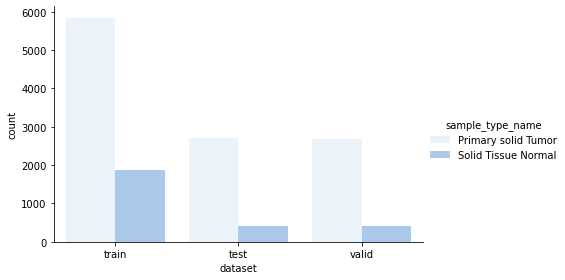

In [12]:
sns.set_color_codes("pastel")

g = sns.catplot(x="dataset", 
            hue="sample_type_name",
            data=train_test_valid, kind="count",
            height=4, aspect=1.5,
            color="b");

#### tumor/normal in each cohort

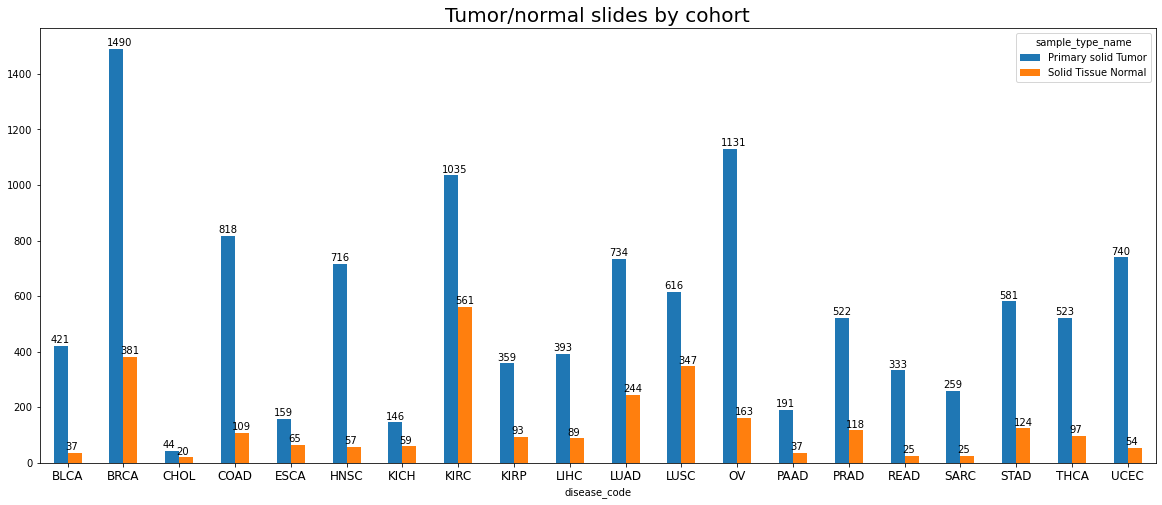

In [13]:
ax = train_test_valid.groupby(['disease_code', 'sample_type_name']).size().unstack(fill_value=0).plot(kind='bar', figsize=(20,8))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()-0.05, p.get_height()+10))
plt.title('Tumor/normal slides by cohort', size=20)
plt.xticks(rotation=0, size=12);

#### tumor/normal in each cohort, stacked bar chart

In [14]:
value_count = train_test_valid.groupby(['disease_code', 'sample_type_name', 'dataset']).size().reset_index(name='values')
value_count.replace('Primary solid Tumor', 'tumor', inplace=True)
value_count.replace('Solid Tissue Normal', 'normal', inplace=True)
value_count.replace('train', '3-train', inplace=True)
value_count.replace('valid', '2-valid', inplace=True)
value_count.replace('test', '1-test', inplace=True)
value_count.columns = ['disease_code', 'type', 'dataset', 'values']
value_count.head(2)

,disease_code,type,dataset,values
0,BLCA,tumor,1-test,133
1,BLCA,tumor,3-train,200


In [15]:
chart = alt.Chart(value_count).mark_bar().encode(x='type:N',
                                                    y=alt.Y('values', axis=alt.Axis(grid=True)), 
                                                    column=alt.Column('disease_code:N'), 
                                                    color='dataset:N')
chart

alt.Chart(...)

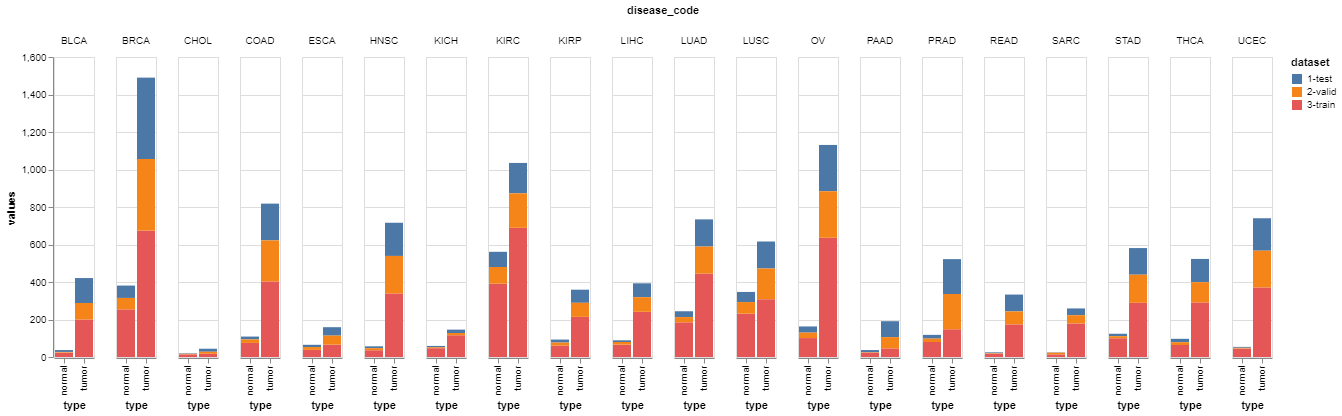

In [16]:
Image(filename='visualization.png', width=1500, height=1200)